# Telcom Customer Churn

The dataset used in this analysis is from Kaggle [Telcom Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn#WA_Fn-UseC_-Telco-Customer-Churn.csv)

### Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." 

### Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

## Gradient Boosting (GBM) Parameter Tuning

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
telcom = pd.read_csv('./Datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
telcom['TotalCharges'] = telcom['TotalCharges'].apply(lambda x: x.replace(' ',''))
telcom['TotalCharges'] = telcom['TotalCharges'].apply(lambda x: float(x) if len(x)!=0 else 0)
telcom_cp = telcom.copy()
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
            'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for col in cat_cols:
    le = preprocessing.LabelEncoder()
    telcom_cp[col] = le.fit_transform(telcom_cp[col].tolist())
    
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
ss = preprocessing.StandardScaler()
telcom_cp[num_cols] = ss.fit_transform(telcom_cp[num_cols])

In [3]:
Features = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 
            'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod', 
            'MonthlyCharges', 'TotalCharges']
X = telcom_cp [Features]
y = telcom_cp ['Churn']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=33)

## Baseline Model

In [4]:
GBM_Summary = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','f1','ROC_AUC'])

Model = GradientBoostingClassifier()
Model_name = 'Baseline Model'

def model_fit(model):
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accu = accuracy_score(y_test,y_pred)
    prec = precision_score(y_test,y_pred)
    reca = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:,1]

    fpr, tpr, th = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    score_summary = {'Model':Model_name,'Accuracy':accu,'Precision':prec,'Recall':reca,'f1':f1,
                                      'ROC_AUC':roc_auc}
    return score_summary

# GBM_Summary.to_csv('./Output/GBM_model.csv')
score_summary=model_fit(Model)
GBM_Summary=GBM_Summary.append(score_summary, ignore_index = True)
GBM_Summary

,Model,Accuracy,Precision,Recall,f1,ROC_AUC
0,Baseline Model,0.801817,0.677507,0.520833,0.588928,0.843251


In [5]:
model = GradientBoostingClassifier().fit(X_train,y_train)

feat_imp = pd.DataFrame(columns=['Features','Feature Importance'])
feat_imp['Features'] = Features
feat_imp['Feature Importance']= model.feature_importances_
feat_imp = feat_imp.sort_values('Feature Importance',ascending=False)
feat_imp['Cumulative Importance'] = feat_imp['Feature Importance'].cumsum(axis = 0)

feat_imp.head()

,Features,Feature Importance,Cumulative Importance
13,Contract,0.400466,0.400466
3,tenure,0.135254,0.535720
16,MonthlyCharges,0.123468,0.659188
17,TotalCharges,0.098548,0.757736
7,OnlineSecurity,0.071734,0.829470


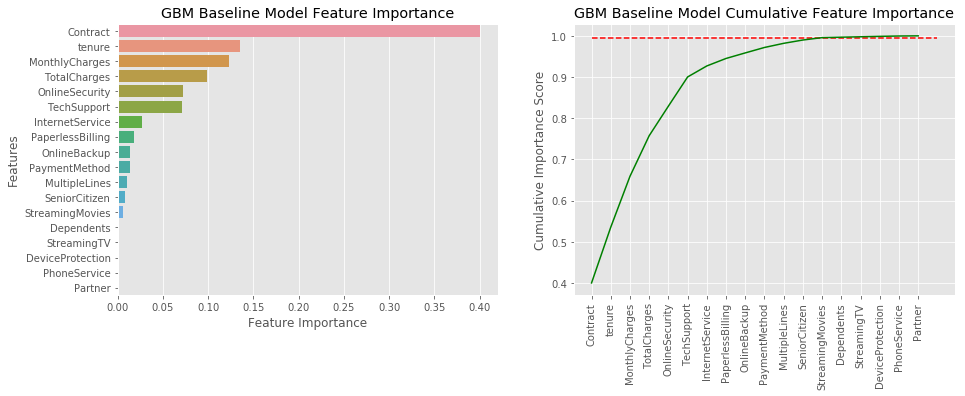

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax1 = sns.barplot(x='Feature Importance', y='Features', data=feat_imp)
plt.title('GBM Baseline Model Feature Importance')


plt.subplot(1,2,2)
plt.plot(range(len(feat_imp)),feat_imp['Cumulative Importance'],color = 'green')
plt.hlines(y = 0.996, xmin=0, xmax=len(feat_imp), color = 'r', linestyles = 'dashed')
plt.xticks(range(len(feat_imp)),feat_imp['Features'], rotation = 'vertical')
plt.ylabel('Cumulative Importance Score')
plt.title('GBM Baseline Model Cumulative Feature Importance')

plt.savefig('./Output/7GBM feature importance.png')
plt.show()

In [7]:
feat_imp99 = feat_imp[feat_imp['Cumulative Importance']<0.996]
Feature99 = feat_imp99['Features'].tolist()
print("{} features has cumulative feature importance ~99.6%, will be used for further model training, including: {} ".format(len(Feature99),Feature99))

13 features has cumulative feature importance ~99.6%, will be used for further model training, including: ['Contract', 'tenure', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaperlessBilling', 'OnlineBackup', 'PaymentMethod', 'MultipleLines', 'SeniorCitizen', 'StreamingMovies'] 


In [8]:
Model_name = '13-Feature Model'
X = telcom_cp [Feature99]
y = telcom_cp ['Churn']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=33)
score_summary=model_fit(Model)
GBM_Summary=GBM_Summary.append(score_summary, ignore_index = True)
GBM_Summary

,Model,Accuracy,Precision,Recall,f1,ROC_AUC
0,Baseline Model,0.801817,0.677507,0.520833,0.588928,0.843251
1,13-Feature Model,0.803521,0.679144,0.529167,0.594848,0.843210


## Hyperparameter Tuning 

In [9]:
param_test1 = {'n_estimators':range(50,301,50),'learning_rate':[0.05,0.1,0.15,0.2]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(min_samples_split=2,min_samples_leaf=1,
                                                               max_depth=3,max_features=None,
                                                               subsample=1,random_state=33),
                        param_grid = param_test1, scoring='roc_auc', cv=5)
gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.15, 'n_estimators': 50}, 0.8508488137145751)

In [10]:
param_test2 = {'max_depth':range(3,7,1), 'min_samples_split':range(2,303,50),'min_samples_leaf':range(1,62,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=50,
                                                               max_features=None, subsample=1, 
                                                               random_state=33), 
                        param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 202},
 0.85140352491212024)

In [11]:
param_test3 = {'max_depth':[2,3], 'min_samples_split':range(120,241,20),'min_samples_leaf':range(50,81,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=50,
                                                               max_features=None, subsample=1, 
                                                               random_state=33), 
                        param_grid = param_test3, scoring='roc_auc', cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'max_depth': 3, 'min_samples_leaf': 70, 'min_samples_split': 160},
 0.85137373902042901)

In [12]:
param_test4 = {'max_features':range(2,10,1), 'subsample':[0.6,0.7,0.8,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=50,
                                                               min_samples_split=160,min_samples_leaf=70,
                                                               max_depth=3,random_state=33), 
                        param_grid = param_test4, scoring='roc_auc', cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 6, 'subsample': 0.9}, 0.85195845494570432)

In [13]:
def model_report(model):
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accu = accuracy_score(y_test,y_pred)
    
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, th = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    cv_train = cross_validate(model, X_train,y_train , cv=5, scoring='roc_auc')['train_score']
    cv_test = cross_validate(model, X_train,y_train , cv=5, scoring='roc_auc')['test_score']
    
    print('Model Summary')
    print('Accuracy: {:.4f}'.format(accu))
    print('AUC_ROC: {:.4f}'.format(roc_auc))
    print('CV score (train): mean - {:.4f} | std - {:.4f}'.format(np.mean(cv_train), np.std(cv_train)))
    
    feat_imp = pd.DataFrame(columns=['Features','Feature Importance'])
    feat_imp['Features'] = Feature99
    feat_imp['Feature Importance']= model.feature_importances_
    feat_imp = feat_imp.sort_values('Feature Importance',ascending=False)
    
    plt.figure(figsize=(12,5))
    sns.barplot(x='Feature Importance', y='Features', data=feat_imp)
    plt.title('GBM Model Feature Importance')

Model Summary
Accuracy: 0.7990
AUC_ROC: 0.8422
CV score (train): mean - 0.8725 | std - 0.0026


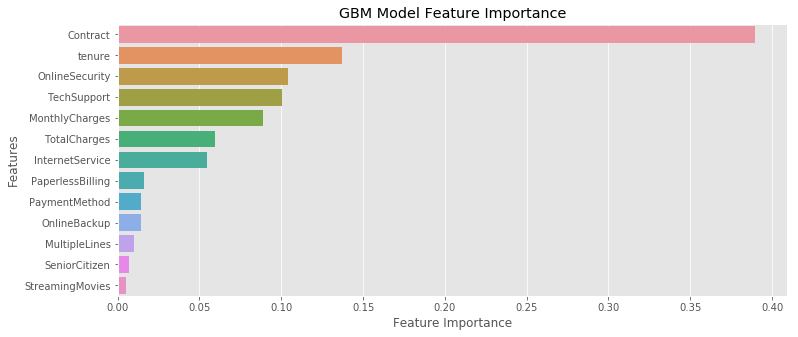

In [14]:
model1 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=50,min_samples_split=160,
                                    min_samples_leaf=70,max_depth=3,max_features=6,
                                    subsample=0.9,random_state=33)
model_report(model1)

Model Summary
Accuracy: 0.8024
AUC_ROC: 0.8423
CV score (train): mean - 0.8734 | std - 0.0027


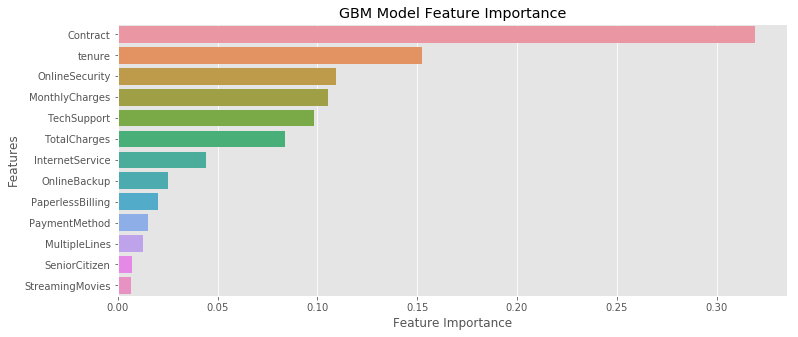

In [15]:
# lower learning rate, increase n_estimator
model2 = GradientBoostingClassifier(learning_rate=0.015, n_estimators=500,min_samples_split=160,
                                    min_samples_leaf=70,max_depth=3,max_features=6,
                                    subsample=0.9,random_state=33)
model_report(model2)